In [108]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# Read data

In [109]:
df_reviews = pd.read_csv('../data/raw/Smaller_Reviews.csv')
df_reviewers = pd.read_csv('../data/raw/Reviewers (Users) CSV.csv')
df_restaurants = pd.read_csv('../data/raw/Resturants CSV.csv')

# Join data

In [110]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     50000 non-null  int64 
 1   date           50000 non-null  object
 2   reviewID       50000 non-null  object
 3   reviewerID     50000 non-null  object
 4   reviewContent  50000 non-null  object
 5   rating         50000 non-null  int64 
 6   usefulCount    50000 non-null  int64 
 7   coolCount      50000 non-null  int64 
 8   funnyCount     50000 non-null  int64 
 9   flagged        50000 non-null  object
 10  restaurantID   50000 non-null  object
dtypes: int64(5), object(6)
memory usage: 4.2+ MB


In [111]:
df_reviewers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16941 entries, 0 to 16940
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewerID       16941 non-null  object
 1   name             16941 non-null  object
 2   location         16931 non-null  object
 3   yelpJoinDate     16941 non-null  object
 4   friendCount      16941 non-null  int64 
 5   reviewCount      16941 non-null  int64 
 6   firstCount       16941 non-null  int64 
 7   usefulCount      16941 non-null  int64 
 8   coolCount        16941 non-null  int64 
 9   funnyCount       16941 non-null  int64 
 10  complimentCount  16941 non-null  int64 
 11  tipCount         16941 non-null  int64 
 12  fanCount         16941 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.7+ MB


In [112]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242652 entries, 0 to 242651
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   restaurantID          242652 non-null  object 
 1   name                  242652 non-null  object 
 2   location              242652 non-null  object 
 3   reviewCount           242652 non-null  int64  
 4   rating                242652 non-null  float64
 5   categories            242652 non-null  object 
 6   address               242652 non-null  object 
 7   Hours                 106328 non-null  object 
 8   GoodforKids           127014 non-null  object 
 9   AcceptsCreditCards    182276 non-null  object 
 10  Parking               138119 non-null  object 
 11  Attire                109277 non-null  object 
 12  GoodforGroups         116329 non-null  object 
 13  PriceRange            179454 non-null  object 
 14  TakesReservations     102629 non-null  object 
 15  

In [113]:
# Columns to exclude prefix, for ease of joining
exclude = ['reviewID', 'reviewerID', 'restaurantID']

# Add prefix to distinctively differentiate columns

df_reviews.columns = [
    col if col in exclude else 'review_' + col
    for col in df_reviews.columns
]

df_reviewers.columns = [
    col if col in exclude else 'reviewer_' + col
    for col in df_reviewers.columns
]

df_restaurants.columns = [
    col if col in exclude else 'restaurant_' + col
    for col in df_restaurants.columns
]

In [114]:
# Merge the dataframes together
merged = df_reviews.merge(
    df_reviewers,
    on='reviewerID',
    how='inner'   
)

merged = merged.merge(
    df_restaurants,
    on='restaurantID',
    how='inner'  
)

print(f'length of merged: {len(merged)}')
merged.head(3)

length of merged: 44518


,review_Unnamed: 0,review_date,reviewID,reviewerID,review_reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,review_flagged,...,restaurant_GoodFor,restaurant_Alcohol,restaurant_NoiseLevel,restaurant_Ambience,restaurant_HasTV,restaurant_Caters,restaurant_WheelchairAccessible,restaurant_webSite,restaurant_phoneNumber,restaurant_filReviewCount
0,680111,7/31/2010,tqpKTXZW9BNhcF1D27cysg,VLDZJMUd5VBBD-OF7EdN6g,Went here for my fiance's surprise birthday di...,4,0,0,0,YR,...,Dinner,Full Bar,Loud,Casual,Yes,No,Yes,http://www.tommysmexican.com,(415) 387-4747,71
1,689600,1/9/2011,0e24ZXHNNmmqlPS_SEv-GQ,dhMSQzqMigb5sx-Z-CPJNQ,This place is so consistent... The prices are ...,4,0,0,0,NR,...,Dinner,Full Bar,Average,Casual,Yes,NaN,Yes,http://www.barriolatinoaventura.co…,(305) 692-4455,7
2,196770,8/6/2010,LsJ5Xz_bsffcNNkPMexfOg,R67_W_HXmsO-bd872AKw8Q,This is one of the lower end Travelodges. If y...,2,0,0,0,NR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.travelodge.com/Travelod…,(916) 361-3131,3


In [115]:
# Replace null and NaN values in the flagged column with a default label
default_label = 'NR'
merged['review_flagged'] = merged['review_flagged'].fillna(default_label)
# Convert the flagged column to binary labels
merged['review_flagged'] = merged['review_flagged'].apply(lambda x: 1 if x == 'Y' else 0)
merged['review_flagged'].unique()

array([0, 1], dtype=int64)

# Class Imbalance and Undersampling

In [116]:
# Check if there is extreme class imbalance
print(merged.groupby('review_flagged')['review_flagged'].count())

review_flagged
0    44115
1      403
Name: review_flagged, dtype: int64


# Feature Engineering for Businesses

In [117]:
df = df_restaurants.copy()

In [118]:
df['restaurant_location']

0                       Alinea - Lincoln Park - Chicago, IL
1                       Hot Doug's - Avondale - Chicago, IL
2                       Tru - Near North Side - Chicago, IL
3                            Crisp - Lakeview - Chicago, IL
4                         Schwa - Wicker Park - Chicago, IL
                                ...                        
242647    Antiquarian's  Delight - South Street District...
242648            Tired Hands Brewing Company - Ardmore, PA
242649    Lemon Grass Thai Restaurant - University City ...
242650             Tang Pho House - CLOSED - Naperville, IL
242651    T & T Lounge - CLOSED - Near West Side - Chica...
Name: restaurant_location, Length: 242652, dtype: object

### Extract location information

In [119]:
# Split by " - "
parts = df['restaurant_location'].str.split(' - ', expand=True)

# parts[1] = neighbourhood
# parts[2] = "City, State"

df['neighbourhood'] = parts[1]

# Now split city/state
df[['city', 'state']] = parts[2].str.split(', ', expand=True)

In [120]:
df[['neighbourhood', 'city', 'state']]

,neighbourhood,city,state
0,Lincoln Park,Chicago,IL
1,Avondale,Chicago,IL
2,Near North Side,Chicago,IL
3,Lakeview,Chicago,IL
4,Wicker Park,Chicago,IL
...,...,...,...
242647,South Street District,Philadelphia,PA
242648,"Ardmore, PA",None,None
242649,University City,Philadelphia,PA
242650,CLOSED,Naperville,IL


# Graph features

In [121]:
# Initialise an undirected graph. Reviewers will be the vertices, and the edges will be the restaurants used
graph = nx.Graph()


# Add the reviewers as the vertices
graph.add_nodes_from(merged['reviewerID'].unique())


# Build graph edges using shared restaurants (if 2 reviewers have the same shared restaurants, add 1 to the list)
restaurant_groupby_df = merged.groupby('restaurantID')['reviewerID'].apply(list)

for reviewer_list in restaurant_groupby_df:
    for i in range(len(reviewer_list)):
        for j in range(i + 1, len(reviewer_list)):
            reviewer_1 = reviewer_list[i]
            reviewer_2 = reviewer_list[j]
            if graph.has_edge(reviewer_1, reviewer_2):
                graph[reviewer_1][reviewer_2]['weight'] += 1
            else:
                graph.add_edge(reviewer_1, reviewer_2, weight = 1)


# We hypothesise that fake review companies are likely to use multiple accounts to comment on the same set of restaurants.
# This means that the accounts with many fake reviews are likely very closely connected together in the graph above, which means the average/max weights edge weights for fake review accounts are likely to be significantly high.
# We also believe that accounts with many fake reviews are likely to operate closely in tight clusters, therefore we believe that these accounts are likely to have a higher clustering coefficient. 
max_weight = {}
avg_weight = {}
for node in graph.nodes():
    weights = [graph[node][neighbour]['weight'] for neighbour in graph.neighbors(node)]
    max_weight[node] = max(weights) if weights else 0
    avg_weight[node] = np.mean(weights) if weights else 0

clustering = nx.clustering(graph, weight='weight')

graph_features = pd.DataFrame({
    'reviewerID': list(graph.nodes()),
    'max_weight': [max_weight[n] for n in graph.nodes()],
    'avg_weight': [avg_weight[n] for n in graph.nodes()],
    'clustering_coeff': [clustering[n] for n in graph.nodes()],
})


#Store everything into merged df
graph_feature_list = ['max_weight', 'avg_weight', 'clustering_coeff']
merged = merged.merge(graph_features, on = 'reviewerID', how = 'left')
merged[graph_feature_list] = merged[graph_feature_list].fillna(0)

print(merged[graph_feature_list].head())

   max_weight  avg_weight  clustering_coeff
0           1         1.0          0.050000
1           1         1.0          0.000000
2           1         1.0          0.000000
3           1         1.0          0.250361
4           1         1.0          0.250000


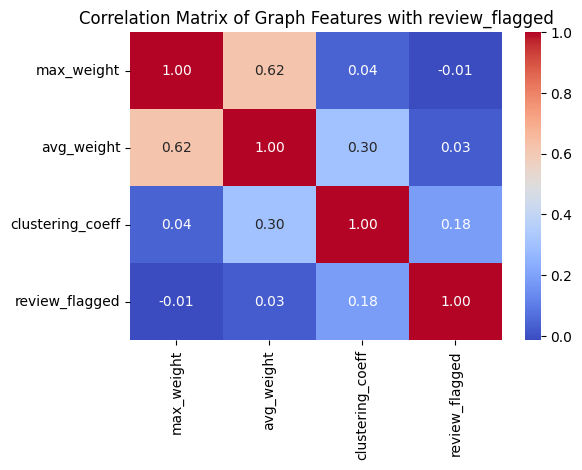

In [122]:
# Check if graph features do have the intended correlation 

graph_corr_matrix = merged[graph_feature_list + ['review_flagged']].corr()


plt.figure(figsize=(6, 4))
sns.heatmap(graph_corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Matrix of Graph Features with review_flagged")
plt.show()

# Train Test Split

In [123]:
X = merged.drop(columns=['review_flagged'])
y = merged['review_flagged']

# Stratified train test split to ensure proportions remain the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

train_df = X_train.copy()
train_df['review_flagged'] = y_train

test_df = X_test.copy()
test_df['review_flagged'] = y_test

#Save as csv
train_df.to_csv('../data/processed/train.csv', index=False)
test_df.to_csv('../data/processed/test.csv', index=False)